# Определение возраста покупателей

## Исследовательский анализ данных

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
data = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

display(data.shape)

Found 7591 validated image filenames.


(7591, 2)

In [14]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


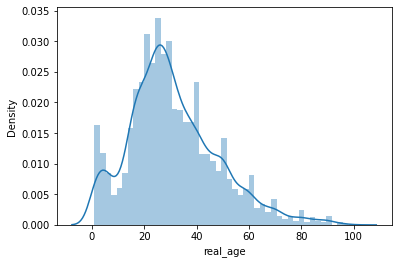

In [17]:
sns_plot = sns.distplot(data['real_age'])
fig = sns_plot.get_figure()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


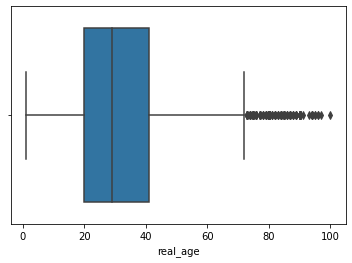

In [18]:
sns_plot = sns.boxplot(data['real_age'])
fig = sns_plot.get_figure()

In [19]:
display(data['real_age'].describe())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [20]:
age_cnt = data['real_age'].value_counts().reset_index()
age_cnt = age_cnt.rename(columns={'index':'age', 'real_age':'cnt'}).sort_values(by='age')
display(age_cnt.head())

,age,cnt
18,1,149
34,2,88
64,3,25
29,4,101
36,5,87


In [21]:
age_cnt['lag_1_cnt'] = age_cnt['cnt'].shift(1, fill_value=88) #88 как кол-во с возрастом 2
age_cnt['diff'] = age_cnt['cnt']-age_cnt['lag_1_cnt']
display(age_cnt.query('diff>=18').sort_values(by='diff', ascending=False).head(10)) # посмотрим на перепады большие возрастов

,age,cnt,lag_1_cnt,diff
0,30,317,164,153
1,25,315,211,104
17,50,156,74,82
29,4,101,25,76
8,16,193,128,65
18,1,149,88,61
13,40,167,107,60
25,14,125,79,46
12,32,174,129,45
10,22,179,143,36


* Данные по возрасту выглядят адекватно. На гистограмме заметны "выборсы" с периодичностью раз в ~10 лет. Можно предположить, что при разметке данных неизвестный возраст округляли. К сожалению, сейчас определить какие значения дозаполнили, поэтому будем работать с тем что есть.

In [22]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

train_datagen_flow = train_datagen.flow_from_directory(
    '/datasets/faces/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    seed=12345)

val_datagen_flow = validation_datagen.flow_from_directory(
    '/datasets/faces/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='validation',
    seed=12345)

features, target = next(train_datagen_flow)

Found 5694 images belonging to 1 classes.
Found 1897 images belonging to 1 classes.


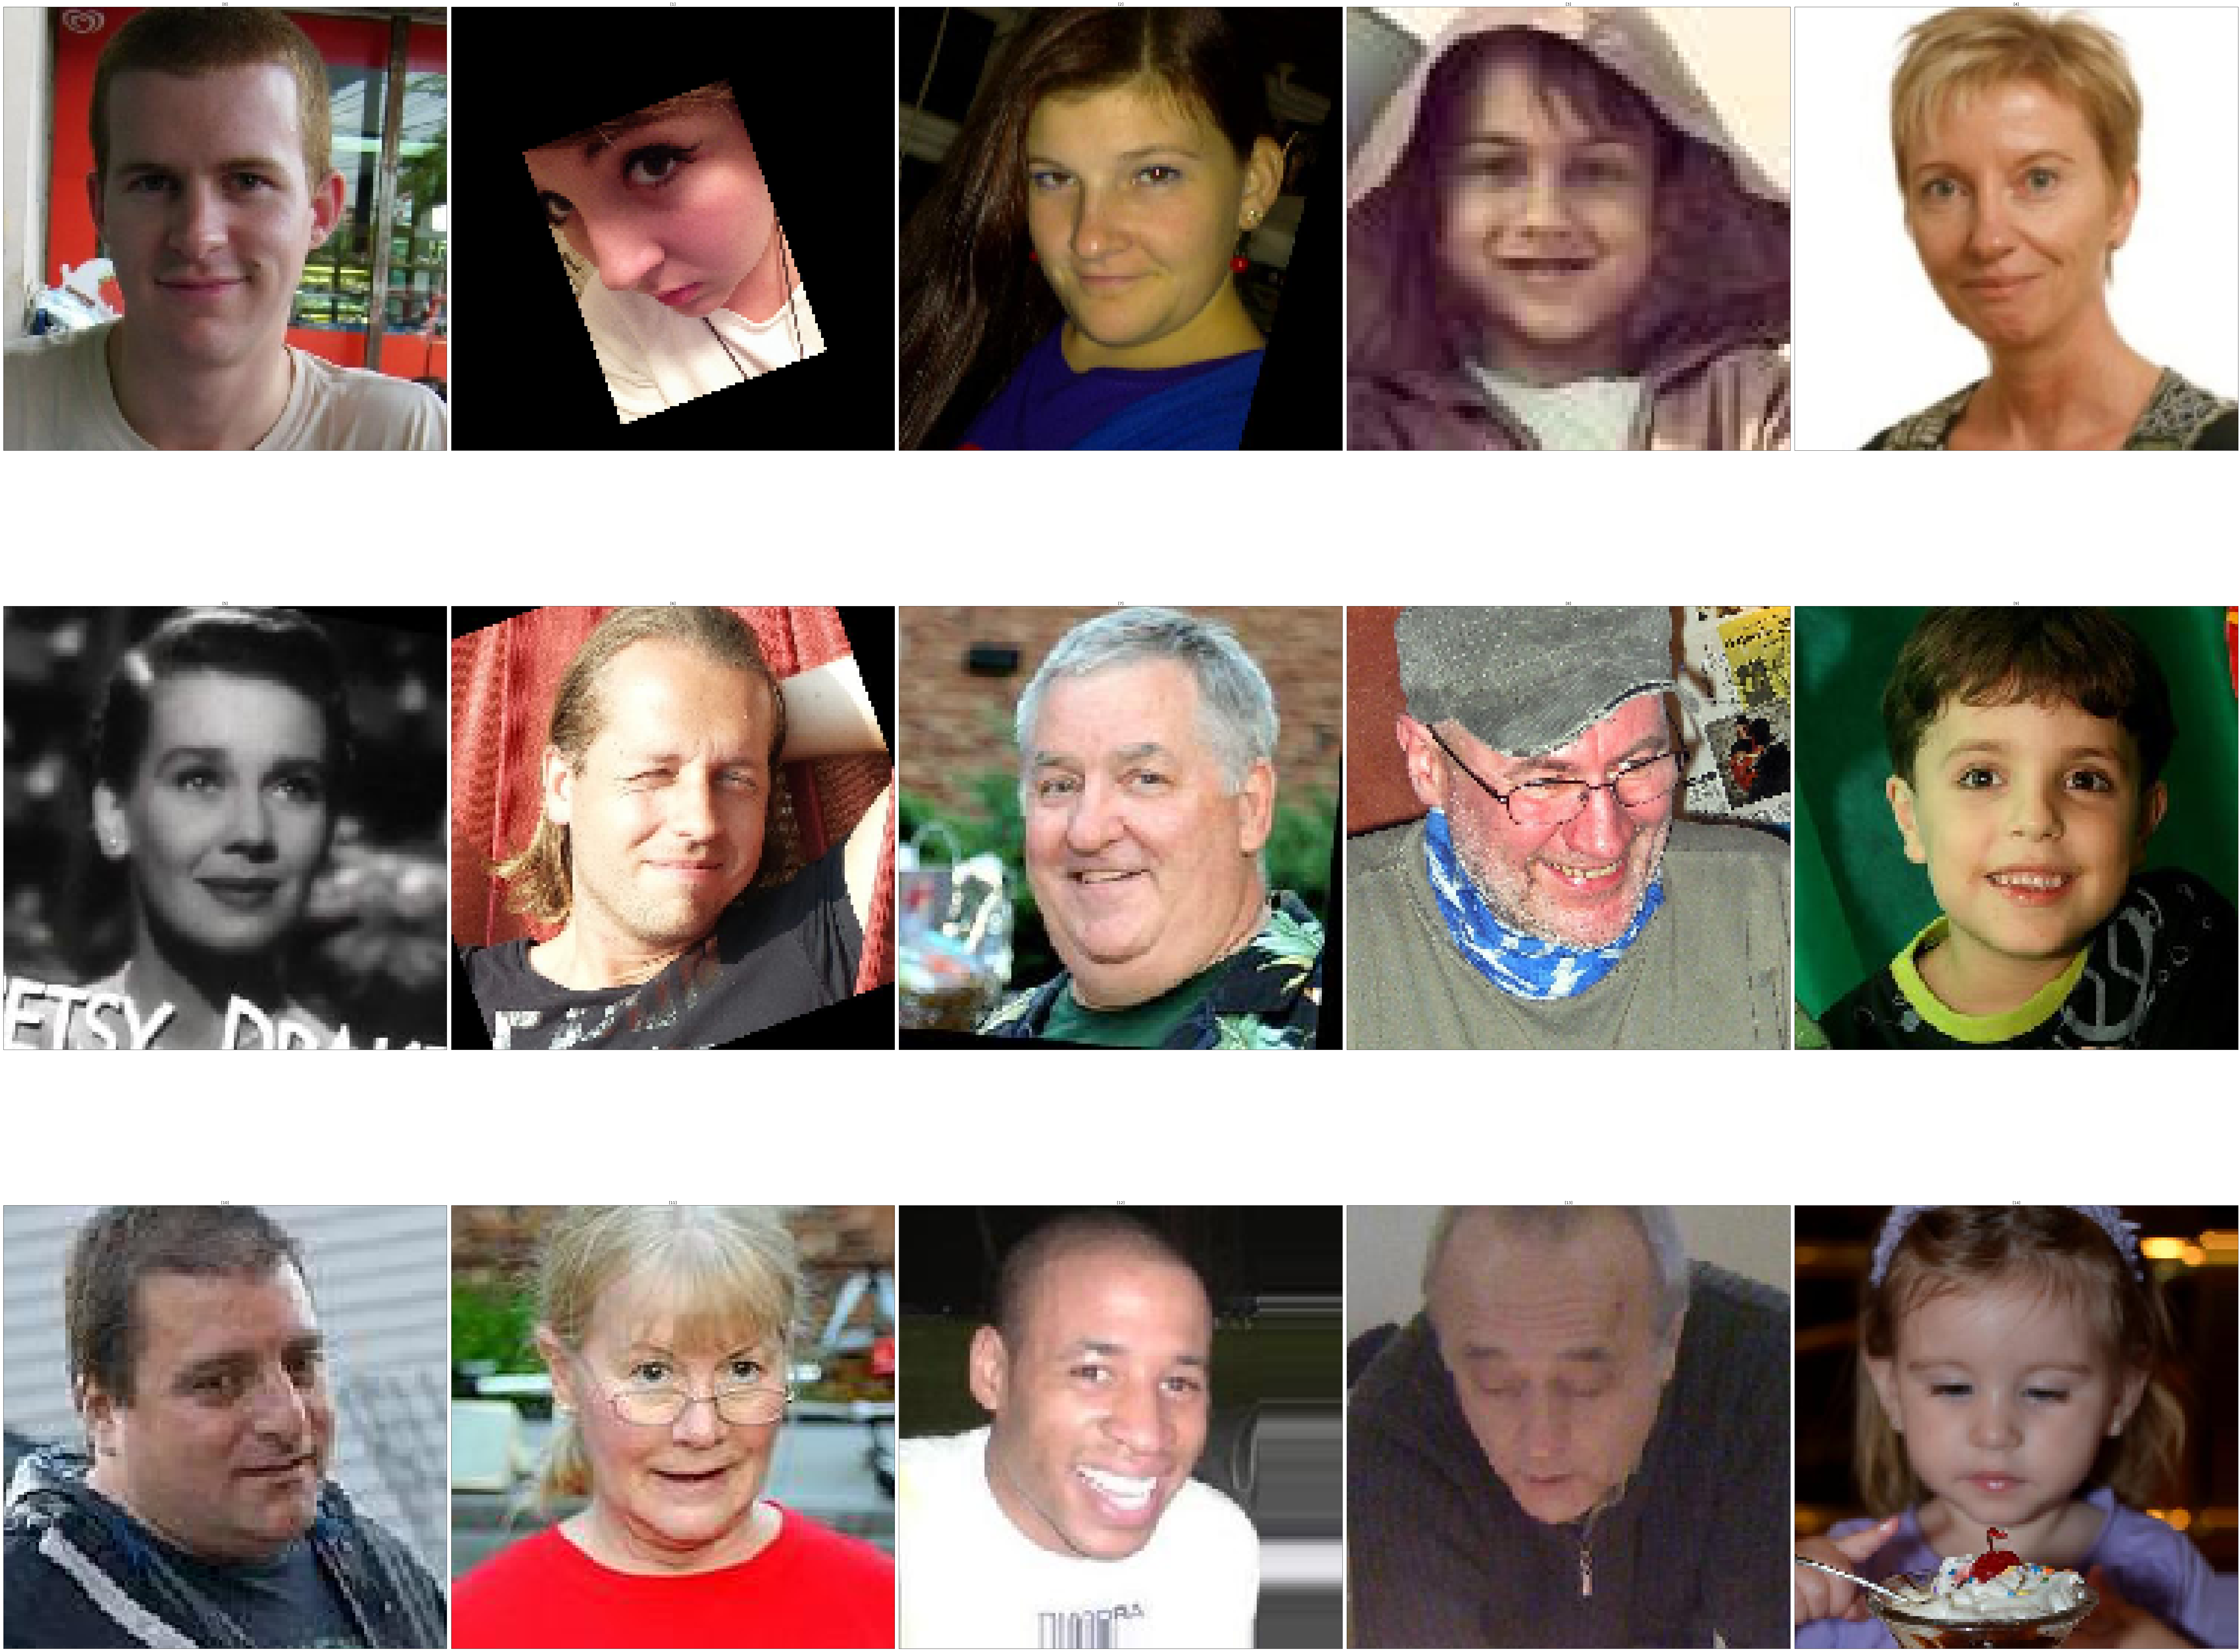

In [35]:
fig = plt.figure(figsize=(100,100))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**

* Данные по возрасту выглядят адекватно. На гистограмме заметны "выборсы" с периодичностью раз в ~10 лет. Можно предположить, что при разметке данных неизвестный возраст округляли
* Выборки из 7591 вполне достаточно, чтобы обучить нейросеть
* Разбили на трейн и тест 75/25%

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, AveragePooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            subset='training',
            class_mode='raw',
            seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            subset='validation',
            class_mode='raw',
            seed=12345)

    return test_gen_flow


def create_model(input_shape):
    resnet = ResNet50(input_shape=input_shape,
                      weights='imagenet',
                      include_top=False)
    model = Sequential()
    model.add(resnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data,
                batch_size=None,
                epochs=10,
                steps_per_epoch=None,
                validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              shuffle=True, verbose=2)

    return model

```

```
Epoch 1/10
2022-08-16 20:10:33.653270: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-16 20:10:34.087346: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 73s - loss: 224.3291 - mae: 10.7544 - val_loss: 977.2499 - val_mae: 26.5209
Epoch 2/10
178/178 - 52s - loss: 75.3351 - mae: 6.5270 - val_loss: 662.8746 - val_mae: 20.6419
Epoch 3/10
178/178 - 54s - loss: 45.9982 - mae: 5.2184 - val_loss: 315.2883 - val_mae: 13.1800
Epoch 4/10
178/178 - 53s - loss: 35.5643 - mae: 4.4991 - val_loss: 106.1555 - val_mae: 7.8000
Epoch 5/10
178/178 - 52s - loss: 27.6451 - mae: 3.9771 - val_loss: 81.5709 - val_mae: 6.8244
Epoch 6/10
178/178 - 52s - loss: 20.7247 - mae: 3.5056 - val_loss: 66.0541 - val_mae: 6.1082
Epoch 7/10
178/178 - 51s - loss: 16.6360 - mae: 3.1197 - val_loss: 68.1522 - val_mae: 6.2538
Epoch 8/10
178/178 - 54s - loss: 15.3282 - mae: 3.0052 - val_loss: 69.0470 - val_mae: 6.2927
Epoch 9/10
178/178 - 56s - loss: 13.0290 - mae: 2.7632 - val_loss: 67.5212 - val_mae: 6.0151
Epoch 10/10
178/178 - 53s - loss: 11.7703 - mae: 2.6060 - val_loss: 63.1795 - val_mae: 5.8995

```

## Анализ обученной модели

* Для улучшения нейросети мы сделали аугментацию при обучении (отразили по горизонтали), что привело к хорошему показателю метрики MAE на тесте. 
* Наилучший результат MAE теста на 10 эпохе = 5.89.